# Discourse-Aware Sentiment Analysis

In [115]:
from __future__ import absolute_import, print_function, unicode_literals

%matplotlib inline

from six import itervalues
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [111]:
# Variables and Constants
ANNOT = True
LGND_FS = 18
LBL_FS = 20
CMAP = sns.cubehelix_palette(1000, start=.5, rot=-.75, as_cmap=True)
HEATMAP_SETTINGS = {"annot": ANNOT, "cmap": CMAP, 
                    "cbar_kws": {"label": "# of Messages"}, 
                    "annot_kws": {"size": 13}}

# Common settings
# sns.set_context("notebook", rc={"figure.figsize": (13, 5), "figure.dpi": 30,
#                             "xtick.labelsize": LGND_FS, "ytick.labelsize": LGND_FS,
#                             "legend.fontsize": 20, "axes.labelsize": LBL_FS})
sns.set_context("paper", rc={"figure.figsize": (12, 6), "figure.dpi": 300,
                            "xtick.labelsize": LGND_FS, "ytick.labelsize": LGND_FS,
                            "legend.fontsize": 20, "axes.labelsize": LBL_FS})

# Common convenience methods
def dict2df(idict):
    idict = pd.DataFrame(idict)
    return idict.pivot("Method", "Lexicon", "score")

## Data

### PotTS

In [74]:
POTTS_STAT = defaultdict(lambda: {"positive": 0, "negative": 0, "neutral": 0})

POTTS_STAT[2] = {"positive": 1000, "negative": 480, "neutral": 780}
POTTS_STAT[3] = {"positive": 502, "negative": 256, "neutral": 320}
POTTS_STAT[4] = {"positive": 150, "negative": 85, "neutral": 89}
POTTS_STAT[5] = {"positive": 51, "negative": 14, "neutral": 23}
POTTS_STAT[6] = {"positive": 2, "negative": 5, "neutral": 4}
POTTS_STAT[7] = {"positive": 1, "negative": 1, "neutral": 0}
POTTS_STAT[8] = {"positive": 1, "negative": 0, "neutral": 0}
POTTS_STAT[12] = {"positive": 0, "negative": 1, "neutral": 0}

POTTS_PD_STAT = pd.DataFrame(POTTS_STAT)
POTTS_PD_STAT

,2,3,4,5,6,7,8,12
negative,480,256,85,14,5,1,0,1
neutral,780,320,89,23,4,0,0,0
positive,1000,502,150,51,2,1,1,0


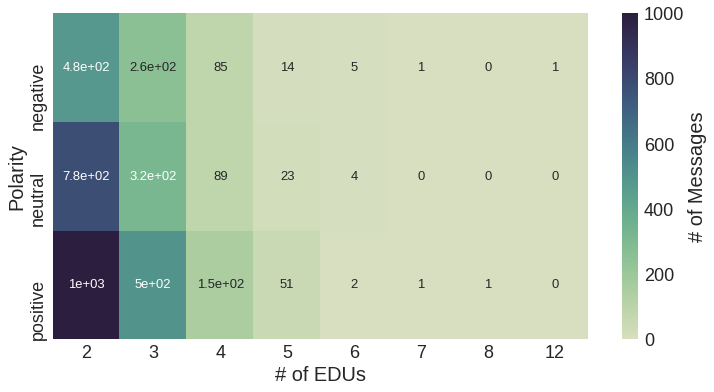

In [113]:
POTTS_PLT = sns.heatmap(POTTS_PD_STAT, **HEATMAP_SETTINGS)
POTTS_PLT.set(xlabel='# of EDUs', ylabel='Polarity')
plt.savefig("dasa_potts_edu_distribution.png", bbox_inches='tight')

### SB10k

In [76]:
SB10K_STAT = defaultdict(lambda: {"positive": 0, "negative": 0, "neutral": 0})

SB10K_STAT[2] = {"positive": 443, "negative": 274, "neutral": 1167}
SB10K_STAT[3] = {"positive": 209, "negative": 123, "neutral": 425}
SB10K_STAT[4] = {"positive": 60, "negative": 57, "neutral": 151}
SB10K_STAT[5] = {"positive": 19, "negative": 15, "neutral": 28}
SB10K_STAT[6] = {"positive": 10, "negative": 9, "neutral": 5}
SB10K_STAT[7] = {"positive": 1, "negative": 2, "neutral": 3}
SB10K_STAT[8] = {"positive": 1, "negative": 2, "neutral": 2}
SB10K_STAT[9] = {"positive": 1, "negative": 1, "neutral": 2}
SB10K_STAT[10] = {"positive": 0, "negative": 0, "neutral": 1}
SB10K_STAT[12] = {"positive": 0, "negative": 1, "neutral": 0}
SB10K_STAT[13] = {"positive": 1, "negative": 0, "neutral": 0}

SB10K_PD_STAT = pd.DataFrame(SB10K_STAT)
SB10K_PD_STAT

,2,3,4,5,6,7,8,9,10,12,13
negative,274,123,57,15,9,2,2,1,0,1,0
neutral,1167,425,151,28,5,3,2,2,1,0,0
positive,443,209,60,19,10,1,1,1,0,0,1


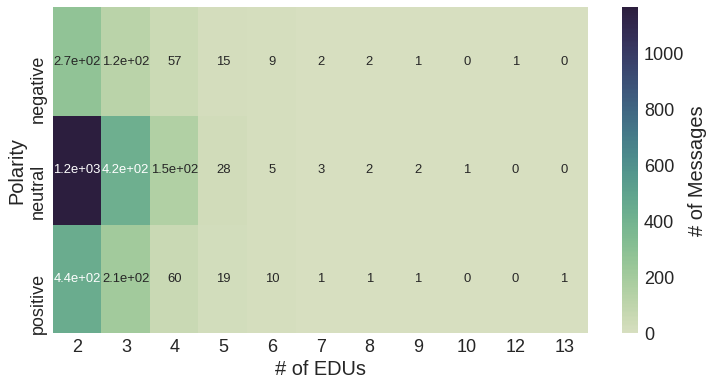

In [112]:
SB10K_PLT = sns.heatmap(SB10K_PD_STAT, **HEATMAP_SETTINGS)
SB10K_PLT.set(xlabel='# of EDUs', ylabel='Polarity')
plt.savefig("dasa_sb10k_edu_distribution.png", bbox_inches='tight')

In [126]:
POTTS_NEG = sum(v["negative"] for v in itervalues(POTTS_STAT))
SB10K_NEG = sum(v["negative"] for v in itervalues(SB10K_STAT))

POTTS_TTL = sum(w for v in itervalues(POTTS_STAT) for w in itervalues(v))
SB10K_TTL = sum(w for v in itervalues(SB10K_STAT) for w in itervalues(v))

float(SB10K_NEG)/float(SB10K_TTL)

0.1606372386325921

In [123]:
SB10K_NEG
POTTS_NEG

842